If you're reading this, you should have already finished the first blog post. Now, with Bayes' Rule in your toolbox, you are ready to tackle a different set of problems.

This post will focus much more on actual data and machine learning concepts. Let's get started!
---

# The Dataset

This time we'll *start* by introducing the dataset. This dataset contains information about different cars, such as their miles-per-gallon, number of cylinders, weight, and so on. It was downloaded from [Kaggle](https://www.kaggle.com/datasets/uciml/autompg-dataset) and is simple enough to let us glide through the following concepts with ease. Let's take a look:

In [1]:
#| echo: false

import matplotlib.pyplot as plt

plt.rc('font', size=12)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('auto-mpg.csv', encoding='windows-1252')
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    397 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [4]:
df.describe()

,mpg,cylinders,displacement,weight,acceleration,model year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


That covers the basic information again, but this time we'll do something even cooler. Let's display a histogram of each of the parameters:

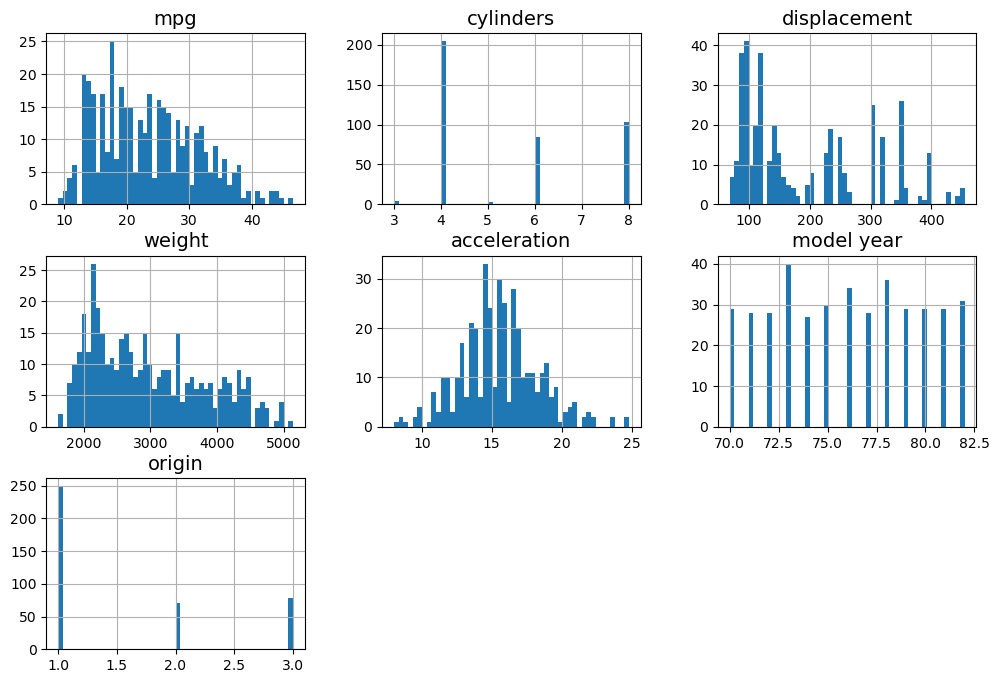

In [5]:
#| fig-align: center

df.hist(bins=50, figsize=(12, 8))
plt.show()

This histogram shows the different values for each feature that every data point has. For example, we can see that a large portion of the cars have between $15$ to $40$ miles-per-gallon. This is cool and all, but for this blog post, we're going to be more concerned with relationships between features. Let's try something new:

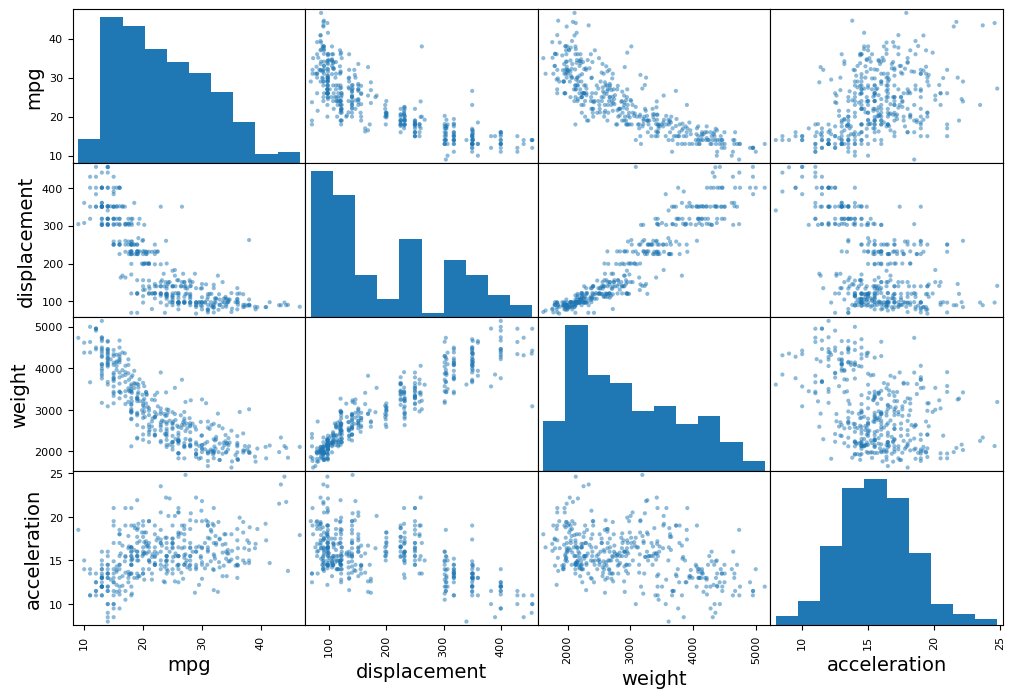

In [ ]:
#| fig-align: center

from pandas.plotting import scatter_matrix

attributes = ["mpg", "displacement", "weight", "acceleration"]
scatter_matrix(df[attributes], figsize=(12, 8))
plt.show()

Now *this* is cool, right? Each plot corresponds to a relationship between two features. For example, the bottom-left plot shows how miles-per-gallon might affect acceleration. From looking at that graph, we can see that there's not much of a relationship. It's somewhat of a big mess. But now look up and to the right one plot to see the relationship between weight and displacement. There's clearly a strong relationship, and we are going to attempt to find it.

Looking at the main diagonal, the plots look completely different. This is because they have the same $x$ and $y$ axes, so their plots really wouldn't give us any important information. Therefore, the `pandas` library knows to replace these plots with histograms, although we've already seen them from the previous figure.

Let's now shift our focus to the graph of weight and displacement:

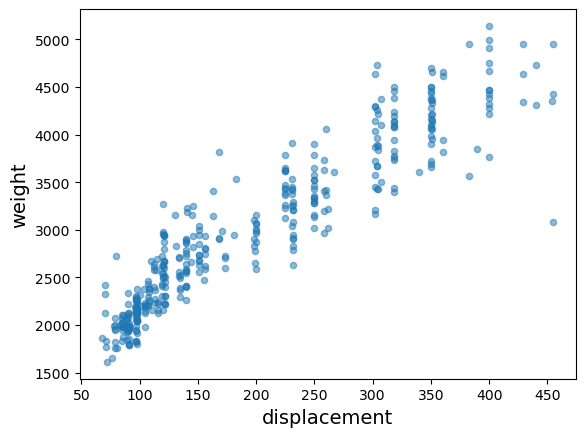

In [15]:
#| fig-align: center

scatter = df.plot.scatter(x='displacement', y='weight', alpha=0.5)

At this point, we'd like to find some sort of way to model this data. Before we do this, however, we need to look at some math.

---

# Linear Regression

Relationships between two variables occur very frequently. For simplicity sake, we will assume that there is one independent variable ($x$) that affects the output variable ($y$), therefore called the *dependent* variable. Mathematically, we write:

$$y = f(x),$$

where $f$ is a function that changes the input in some way to produce the output.

We can also use subscripts to represent having more than one input affecting the output, like so:

$$y = f(x_0, x_1, x_2, \ldots)$$

Even with a large amount of total variables, determining the relationship between independent variables and dependent variables is as simple as finding $f$. Or so you would think.

When it comes to real-world relationships, there are very few cases where things are this simple. For example, think about a company that is using commercials to try to increase sales of their product. It would be very nice if doubling the amount of advertisement playing at any given time on television caused twice as many purchases, but that is simply not what happens. A small increase in ads may lead to a similar, deterministic increase in sales, but at a certain point people might get fed up with the ads and stop purchasing the product entirely.

This observation is even more exaggerated at the individual level. If you assume that all humans behave the same way, then you could easily reason that a change in the output variable will be consistent across all people, but this is also not true. Human beings are individuals, with their own thoughts and opinions and irrationality. At some point, someone may stop purchasing your product just because they don't feel like it anymore.

To remedy this, we assume that there is still a function that can describe the relationship between our variables, but we also add on an error term:

$$Y = f(X) + \epsilon$$

This error term accounts for the other variables that are too complex to account for. It is true that if we knew every single variable, then we wouldn't need the error term. But alas, this is the way things are.

In creating our model, we will try to find an approximate function that will give an approximate output for some input. In theory, this model will have reduced the error as much as possible:

$$\hat{Y} = \hat{f}(X)$$

*The little "hats" on top indicate that these are approximations.*

To create our model, we need to ***train*** it on the available data, usually called the ***training set***. If we could train forever, we would remove all of the error within our model, known as the ***reducible error***. If our approximate function correctly represents the actual relationship between data, then we can come very close to this. However, since each data point is affected by variables that we can't keep track of, there is some ***irreducible error*** that will *always* exist.

So, we have some understanding of the theory, but how do we do it in practice? There are quite a few methods, but the simplest is ***Linear Regression***. Linear Regression essentially makes the assumption that the input(s) has a linear contribution to the output. In other words, doubling the input doubles the output, halving the input halves the output, and so on. A line has a very simple equation:

$$y = mx + b,$$

where $m$ is the ***slope***, which signifies the increase or decrease in output for a change in input, and ***b*** represents how vertically shifted the values are from the start. Let's write it in a more appropriate form:

$$\hat{Y} = \hat{\beta}_1X + \hat{\beta}_0$$

I've changed the $m$ and $b$ constants and used subscripts, but the idea is the same. We can also extend this idea to multiple independent variables:

$$\hat{Y} = \hat{\beta}_0 + \sum_{i = 1}^N \hat{\beta}_iX_i$$

The hats on these constants also indicate that they are approximations of the true constants (if the data actually has a linear relationship).

So the next question is, how do we find the constants? This is where things begin to get a little complicated.

Computers do this by minimizing some value that corresponds to the error of our model. There are a few good choices, but the most common is known as the ***Mean Squared Error*** (MSE):

$$\mathrm{MSE} = \frac{1}{N}\sum_{i = 1}^N (Y_i - \hat{f}(X_i))^2$$

The inside of the parantheses show the difference between the actual measured output value of the data and the currne iteration our model's output value for the same input. This difference is then squared. After getting this squared difference for every data point, they're all summed up, and divided by the total number of data points.

For simple Linear Regression (one input variable), formulas for these constants can be found directly. First, we plug in the linear equation for $\hat{f}(X)$:

$$\begin{equation}
\begin{split}
\frac{1}{N}\sum_{i = 1}^N (Y_i - \hat{f}(X_i))^2 &= \frac{1}{N}\sum_{i = 1}^N (Y_i - \hat{\beta}_1X_i - \hat{\beta}_0)^2\\
&= \frac{1}{N}\sum_{i = 1}^N (Y_i^2 - 2\hat{\beta}_1X_iY_i - 2\hat{\beta}_0Y_i + \hat{\beta}_1^2X_i^2 + 2\hat{\beta}_0\hat{\beta}_1X_i + \hat{\beta}_0^2)
\end{split}
\end{equation}$$

Pretty nasty. Now, we'd like to minimize this to find the coefficient values. Let's imagine that the error for each coefficient looks something like this:

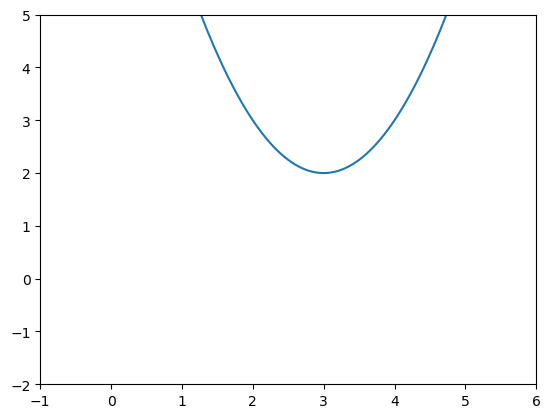

In [201]:
#| echo: false
#| fig-align: center

parabolaX = list(range(-50, 150, 1))
parabolaX = [element / 20 for element in parabolaX]
parabolaY = [(element * element) - (6 * element) + 11 for element in parabolaX]

plt.plot(parabolaX, parabolaY)
plt.axis([-1, 6, -2, 5])
plt.show()

Our error shouldn't have a maximum, since our line could always be worse, but it should definitely have a minimum, so we know that this graph is somewhat representative of how the error will change as we change the coefficients. To mimimize this error, we need to find the coefficient values that will bring the error down into the very bottom of the valley. We can do this by taking the partial derivative with respect to the coefficient values. This is because the derivative represents the rate of change of a function with respect to a changing independent variable. If we find this derivative, and set it equal to zero, we should have reached an inflection point on the graph, since the derivative must switch between negative and positive values to flip the direction of the function.

Here is a visual representation of the derivative of this curve:

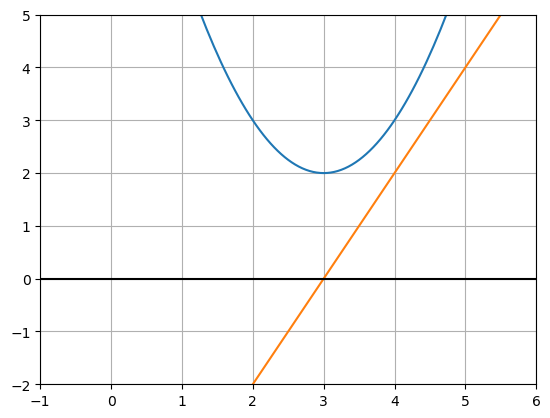

In [204]:
#| echo: false
#| fig-align: center

deriv = [(2 * element) - 6 for element in parabolaX]

plt.plot(parabolaX, parabolaY)
plt.plot(parabolaX, deriv)
plt.plot(parabolaX, [0] * len(parabolaX), "black")
plt.axis([-1, 6, -2, 5])
plt.grid()
plt.show()

Notice how the line that represents the derivative of the curve passes through $y = 0$ right at $x = 3$, the exact same spot where the parabolic curve flips directions. Therefore, to minimize the error, we can take the derivative of our error with respect to each of the variables, set them equal to zero, and solve for the coefficients.

We'll start with the easier one ($\hat{\beta}_0$) first:

$$\frac{\partial}{\partial \hat{\beta}_0}\mathrm{MSE} = \frac{1}{N}\sum_{i = 1}^N (-2Y_i + 2\hat{\beta}_1X_i + 2\hat{\beta}_0)$$

Now that we have the partial derivative, we can set it equal to zero to find the minimum:

$$\newcommand{\olsi}[1]{\,\overline{\!{#1}}}$$

$$\begin{equation}
\begin{split}
\frac{1}{N}\sum_{i = 1}^N (-2Y_i + 2\hat{\beta}_1X_i + 2\hat{\beta}_0) &= 0\\
-\frac{2}{N}\sum_{i = 1}^NY_i + \frac{2\hat{\beta}_1}{N}\sum_{i = 1}^NX_i + \frac{2\hat{\beta}_0}{N}\sum_{i = 1}^N 1 &= 0\\
-\olsi{Y} + \hat{\beta}_1\olsi{X} + \hat{\beta}_0 &= 0
\end{split}
\end{equation}$$

Rearranging:

$$\hat{\beta}_0 = \olsi{Y} - \hat{\beta}_1\olsi{X},$$

where $\olsi{X}$ and $\olsi{Y}$ are the averages of $X$ and $Y$, respectively.

Now, let's do the same thing for $\hat{\beta}_1$. Taking the partial derivative:

$$\frac{\partial}{\partial \hat{\beta}_1}\mathrm{MSE} = \frac{1}{N}\sum_{i = 1}^N (-2X_iY_i + 2\hat{\beta}_1X_i^2 + 2\hat{\beta}_0X_i)$$

And setting it equal to zero:

$$\begin{equation}
\begin{split}
\frac{1}{N}\sum_{i = 1}^N (-2X_iY_i + 2\hat{\beta}_1X_i^2 + 2\hat{\beta}_0X_i) &= 0\\
-\frac{2}{N}\sum_{i = 1}^N X_iY_i + \frac{2\hat{\beta}_1}{N}\sum_{i = 1}^NX_i^2 + \frac{2\hat{\beta}_0}{N}\sum_{i = 1}^NX_i &= 0\\
\end{split}
\end{equation}$$

Substituting our new equation in for $\hat{\beta}_1$:

$$\begin{equation}
\begin{split}
-\frac{2}{N}\sum_{i = 1}^N X_iY_i + \frac{2\hat{\beta}_1}{N}\sum_{i = 1}^NX_i^2 + \frac{2}{N}(\olsi{Y} - \hat{\beta}_1\olsi{X})\sum_{i = 1}^NX_i &= 0\\
-\frac{2}{N}\sum_{i = 1}^N X_iY_i + \frac{2\hat{\beta}_1}{N}\sum_{i = 1}^NX_i^2 + \frac{2}{N}\sum_{i = 1}^NX_i\olsi{Y} - \frac{2\hat{\beta}_1}{N}\sum_{i = 1}^NX_i\olsi{X} &= 0\\
\frac{2}{N}\left(\sum_{i = 1}^NX_i\olsi{Y} - \sum_{i = 1}^N X_iY_i\right) + \frac{2\hat{\beta}_1}{N}\left(\sum_{i = 1}^NX_i^2 - \sum_{i = 1}^NX_i\olsi{X}\right) &= 0\\
\sum_{i = 1}^N(X_i\olsi{Y} - X_iY_i) + \hat{\beta}_1\sum_{i = 1}^N(X_i^2 - X_i\olsi{X}) &= 0\\
-\sum_{i = 1}^NX_i(Y_i - \olsi{Y}) + \hat{\beta}_1\sum_{i = 1}^NX_i(X_i - \olsi{X}) &= 0
\end{split}
\end{equation}$$

Rearranging:

$$\begin{equation}
\begin{split}
\hat{\beta}_1 &= \frac{\sum\limits_{i = 1}^NX_i(Y_i - \olsi{Y})}{\sum\limits_{i = 1}^NX_i(X_i - \olsi{X})}
\end{split}
\end{equation}$$

At this point, we have an equation for $\hat{\beta}_1$, but this may not be the form you've seen it in before. In order to get to that form, we need to do a unique manipulation. First, we need to note the following relationship:

$$\begin{equation}
\begin{split}
\sum\limits_{i = 1}^N (X_i - \olsi{X}) &= \left( X_0 -  \frac{X_0 + X_1 + \ldots}{N} \right) + \left( X_1 -  \frac{X_0 + X_1 + \ldots}{N} \right) + \ldots\\
&= \left( X_0 + X_1 + \ldots \right) - N\left( \frac{X_0 + X_1 + \ldots}{N} \right) = 0
\end{split}
\end{equation}$$

The same exact process can be applied with $Y$ and $\olsi{Y}$. So, our two new equations are:

$$\begin{equation}
\begin{split}
\sum\limits_{i = 1}^N (X_i - \olsi{X}) &= 0\\
\sum\limits_{i = 1}^N (Y_i - \olsi{Y}) &= 0
\end{split}
\end{equation}$$

Since the left side is equal to zero, we can multiply it by whatever constant we'd like and the relationship would still be maintained. We will multiply both equations by $\olsi{X}$:

$$\begin{equation}
\begin{split}
\olsi{X}\sum\limits_{i = 1}^N (X_i - \olsi{X}) &= \sum\limits_{i = 1}^N \olsi{X}(X_i - \olsi{X}) = 0\\
\olsi{X}\sum\limits_{i = 1}^N (Y_i - \olsi{Y}) &= \sum\limits_{i = 1}^N \olsi{X}(Y_i - \olsi{Y}) = 0
\end{split}
\end{equation}$$

These equations will be used to perform some algebraic wizardry. Since both of these equations are equal to zero, we can subtract them from the numerator and denominator of our equation for $\hat{\beta}_1$ without changing anything:

$$\begin{equation}
\begin{split}
\hat{\beta}_1 = \frac{\sum\limits_{i = 1}^NX_i(Y_i - \olsi{Y})}{\sum\limits_{i = 1}^NX_i(X_i - \olsi{X})} &= \frac{\sum\limits_{i = 1}^NX_i(Y_i - \olsi{Y}) - \sum\limits_{i = 1}^N \olsi{X}(Y_i - \olsi{Y})}{\sum\limits_{i = 1}^NX_i(X_i - \olsi{X}) - \sum\limits_{i = 1}^N \olsi{X}(X_i - \olsi{X})}\\
&= \frac{\sum\limits_{i = 1}^N\left[X_i(Y_i - \olsi{Y}) - \olsi{X}(Y_i - \olsi{Y})\right]}{\sum\limits_{i = 1}^N\left[X_i(X_i - \olsi{X}) - \olsi{X}(X_i - \olsi{X})\right]}\\
&= \frac{\sum\limits_{i = 1}^N\left[(X_i - \olsi{X})(Y_i - \olsi{Y})\right]}{\sum\limits_{i = 1}^N\left[(X_i - \olsi{X})(X_i - \olsi{X})\right]}\\
&= \frac{\sum\limits_{i = 1}^N(X_i - \olsi{X})(Y_i - \olsi{Y})}{\sum\limits_{i = 1}^N(X_i - \olsi{X})^2}
\end{split}
\end{equation}$$

Finally! We got a (somewhat) simple looking equation for our second coefficient. There is another representation, but it is more complicated and doesn't provide many benefits over this one.

Let's recap:

$$\hat{\beta}_0 = \olsi{Y} - \hat{\beta}_1\olsi{X},$$

$$\hat{\beta}_1 = \frac{\sum\limits_{i = 1}^N(X_i - \olsi{X})(Y_i - \olsi{Y})}{\sum\limits_{i = 1}^N(X_i - \olsi{X})^2},$$

where

$$\olsi{X} = \frac{1}{N}\sum\limits_{i = 1}^N X_i$$

$$\mathrm{and}$$

$$\olsi{Y} = \frac{1}{N}\sum\limits_{i = 1}^N Y_i$$

Now that we have our equations, let's try applying them.

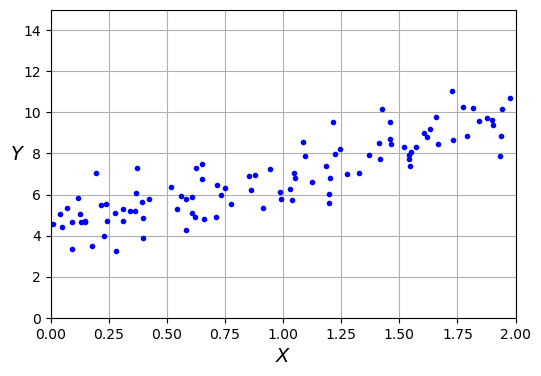

In [118]:
#| fig-align: center

import numpy as np

np.random.seed(42)
N = 100
X = 2 * np.random.rand(m, 1)
Y = 4 + 3 * X + np.random.randn(m, 1)

X = [element[0] for element in X]
Y = [element[0] for element in Y]

plt.figure(figsize=(6, 4))
plt.plot(X, Y, "b.")
plt.xlabel("$X$")
plt.ylabel("$Y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.show()

This is fake data that was generated with the sole purpose of using our new equations to fit a line to it. Let's try it out!

In [119]:
productSum = 0
squareSum = 0

X_Mean = sum(X) / N
Y_Mean = sum(Y) / N

for i in range(0, N):
    productSum += (X[i] - X_Mean) * (Y[i] - Y_Mean)
    squareSum += (X[i] - X_Mean) * (X[i] - X_Mean)
    
b1 = productSum / squareSum
b0 = Y_Mean - (b1 * X_Mean)

print(b0)
print(b1)

4.215096157546749
2.770113386438484


These are close to the coefficients that were used to generate the randomized data in the first place ($4$ and $3$), so we know we're on the right track. Let's plot it to see what the graph looks like:

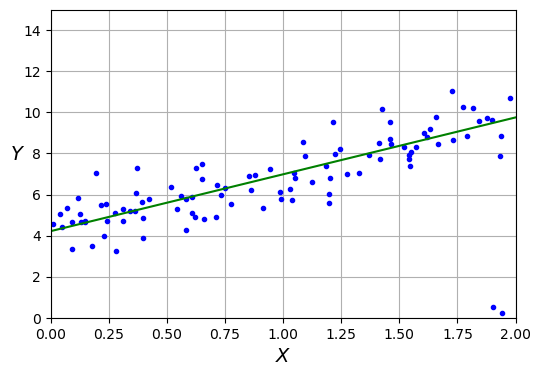

In [123]:
#| fig-align: center

xAxis = np.asarray(range(0, 100))
yAxis = (xAxis * b1) + b0

plt.figure(figsize=(6, 4))
plt.plot(X, Y, "b.")
plt.plot(xAxis, yAxis, "g")
plt.xlabel("$X$")
plt.ylabel("$Y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.show()

Nice! We see that the line described by our coefficients seems to pass as close to all the points as it can.

You may wonder, "why did we try to minimize the Mean Squared Error?" Why not just the difference between the true value and estimated value? Well, some true values may be above our estimates, and some may be below. A worst-case scenario would occur when this occurs over and over, and all of the positive values cancel with the negative values, giving us no information. The squaring process removes all negatives.

Your next question may be, "then why not use the absolute value instead of squaring?" And that is a very good point. In fact, this can be done. The reason it typically isn't is that the Mean Squared Error has some nice properties with certain distributions and have a deeper connection to the data in general. However, the absolute value error is used enough to have its own name: the ***L-1 Norm***. The square root of our Mean Squared Error, (also called the Root Mean Square (RMS)) is called the ***L-2 Norm***. There are technically an infinite amount of other norms, but the L-1 and L-2 norms are the most common ones used in practice.

The L-1 Norm is preferred when there are a few outliers in the data. This is because the Mean Squared Error exacerbates the error that outliers have, since everything is squared. Let's take a look at how much this affects our line by adding a couple outliers:

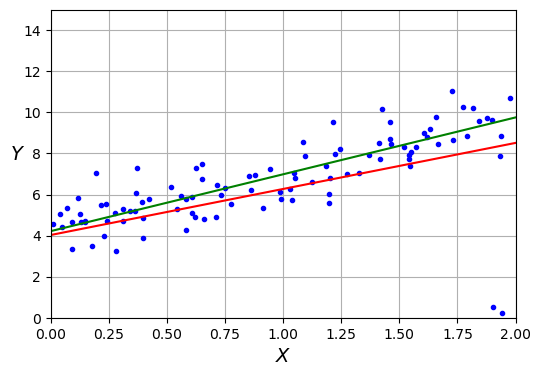

In [121]:
#| fig-align: center

randomIndices = [i for (i, _) in enumerate(X) if X[i] > 1.9]

Y[randomIndices[0]] = 0.5
Y[randomIndices[1]] = 0.25

productSum = 0
squareSum = 0

X_Mean = sum(X) / N
Y_Mean = sum(Y) / N

for i in range(0, N):
    productSum += (X[i] - X_Mean) * (Y[i] - Y_Mean)
    squareSum += (X[i] - X_Mean) * (X[i] - X_Mean)
    
newB1 = productSum / squareSum
newB0 = Y_Mean - (b1 * X_Mean)

newYAxis = (xAxis * newB1) + newB0

plt.figure(figsize=(6, 4))
plt.plot(X, Y, "b.")
plt.plot(xAxis, yAxis, "g")
plt.plot(xAxis, newYAxis, "r")
plt.xlabel("$X$")
plt.ylabel("$Y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.show()

As you can see, it took only *two* outliers to move our new line (red) a substantial amount. In this case, it might be better to use the L-1 norm.

Let's try to fit a line to our dataset this time. We'll use `scikit-learn`'s `LinearRegression` class to do it for us:

In [129]:
from sklearn.linear_model import LinearRegression

disp = np.asarray(df['displacement']).reshape(-1, 1)
weight = np.asarray(df['weight']).reshape(-1, 1)

lin_reg = LinearRegression()
lin_reg.fit(disp, weight)
lin_reg.intercept_, lin_reg.coef_

(array([1505.01873083]), array([[7.57605909]]))

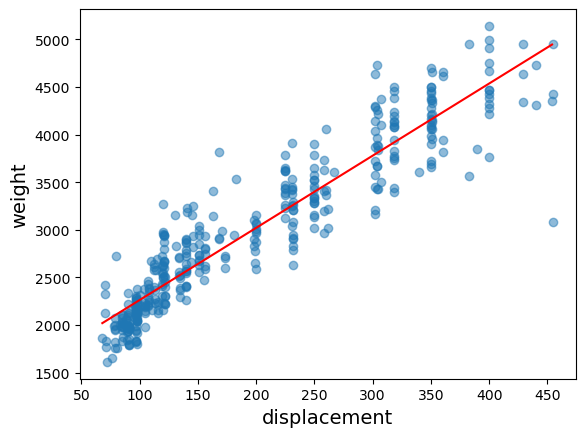

In [146]:
#| fign-align: center

xAxis = range(int(min(disp)), int(max(disp)))
yAxis = (xAxis * lin_reg.coef_[0]) + lin_reg.intercept_[0]

plt.scatter(df['displacement'], df['weight'], alpha=0.5)
plt.plot(xAxis, yAxis, "r")
plt.xlabel('displacement')
plt.ylabel('weight')
plt.show()

Looks pretty solid! This model can now be used to estimate the weight of a car just by knowing the displacement. Let's use a specific car as an example and measure how close our prediction was. We will use the Lexus LS 400, which has a $\sim250~\mathrm{in}^3$ displacement and a curb weight of $\sim3700~\mathrm{lbs}$:

In [149]:
dispTest = 250
weightTest = (lin_reg.coef_ * dispTest) + lin_reg.intercept_
weightTest[0][0]

3399.0335038967237

Not too bad! With an error of about $\frac{3700 - 3400}{3700} \approx 8.1\%$, we're doing pretty well, especially considering that our dataset doesn't contain any Lexus cars:

Of course, the variation of the weight for each displacement is due to other variables affecting the weight. In this case, if you want to determine how multiple variables are affecting the output, you can use Multiple Linear Regression. Since there is a coefficient for each independent variable, finding the formulas directly is incredibly difficult, and only gets harder as more variables are added. Of course, this is why we invented computers; to do our dirty work for us.

*This section will be expanded in the future to include Linear Regression using multiple features.*

---

# Nonlinear Regression

Let's look at another plot from our data:

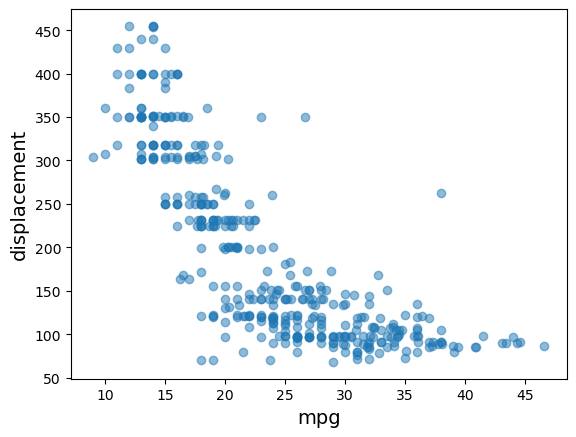

In [205]:
#| fign-align: center

plt.scatter(df['mpg'], df['displacement'], alpha=0.5)
plt.xlabel('mpg')
plt.ylabel('displacement')
plt.show()

We can see that fitting a line to this would be pretty difficult. We might have some accurrate approximations for miles-per-gallon values between $15$ and $25$, but the data seems to level out after this point. In this case, we need to find a non-linear model. Luckily, `scikit-learn` has our back:

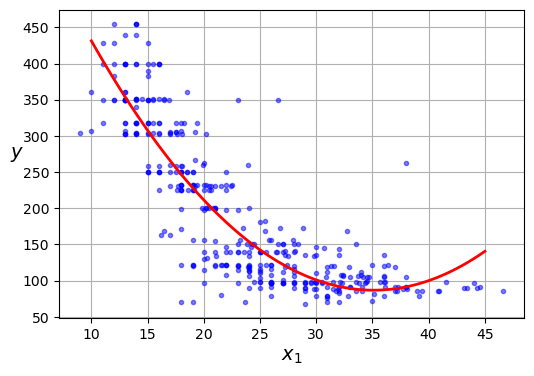

In [228]:
#| fign-align: center

from sklearn.preprocessing import PolynomialFeatures

disp = np.asarray(df['displacement']).reshape(-1, 1)
mpg = np.asarray(df['mpg']).reshape(-1, 1)

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(mpg)

lin_reg = LinearRegression()
lin_reg.fit(X_poly, disp)
lin_reg.intercept_, lin_reg.coef_

X_new = np.linspace(10, 45, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

plt.figure(figsize=(6, 4))
plt.plot(mpg, disp, "b.", alpha=0.5)
plt.plot(X_new, y_new, "r-", linewidth=2)
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.grid()
plt.show()

Not too bad! We shaped this using a polynomial of degree $2$, otherwise known as a parabola. Would it become more accurate if we increased the degree value? Let's try:

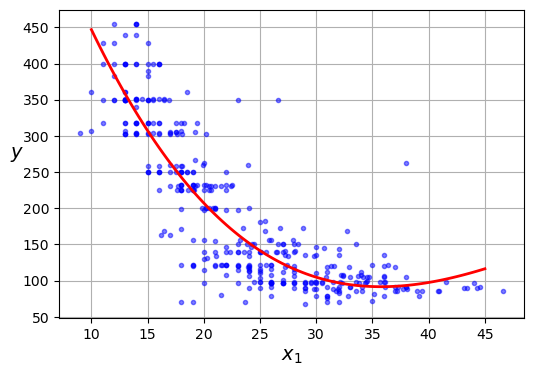

In [229]:
#| fign-align: center

from sklearn.preprocessing import PolynomialFeatures

disp = np.asarray(df['displacement']).reshape(-1, 1)
mpg = np.asarray(df['mpg']).reshape(-1, 1)

poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly_features.fit_transform(mpg)

lin_reg = LinearRegression()
lin_reg.fit(X_poly, disp)
lin_reg.intercept_, lin_reg.coef_

X_new = np.linspace(10, 45, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

plt.figure(figsize=(6, 4))
plt.plot(mpg, disp, "b.", alpha=0.5)
plt.plot(X_new, y_new, "r-", linewidth=2)
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.grid()
plt.show()

Changing the degree to $3$ definitely seems to have lowered the curve at the end, which is nice! But why can't we just keep increasing the degree? Well, as you increase the flexibility that the model has, you begin to do something called ***overfitting***. In simple terms, your model is trying to match too closely to the data in your training set. This makes your training set error look really low, which appears to be a good thing, but the problem is that any predictions made will be *less* accurate. Essentially, the model is finding patterns that aren't really there, and is trying to match them as closely as possible. Another way of saying the same thing is to say that the model has ***high variance***.

***Underfitting*** occurs when the model doesn't fit the training data particulary well, but generalizes to new data well (only because it's so simple). You can also say that this model has ***high bias***.

In machine learning, bias and variance are inescapable. Raising your bias will lower your variance and result in underfitting. Raising your variance will lower your bias and result in overfitting. This is known as the ***bias-variance tradeoff***. The question of finding a good model is the same as asking for a model that minimizes both bias and variance as much as possible.